In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')


In [ ]:
df = pd.read_csv('vendas_produto_alfa_processadas.csv')


In [43]:

def create_time_series_features(df):
    df = df.copy()
    
    df['data'] = pd.to_datetime(df['data'])
    df = df.sort_values('data').reset_index(drop=True)
    
    #df['dia_semana_sin'] = np.sin(2 * np.pi * df['dia_da_semana'].astype('category').cat.codes / 7)
    #df['dia_semana_cos'] = np.cos(2 * np.pi * df['dia_da_semana'].astype('category').cat.codes / 7)
    
    for lag in [1, 7, 14, 21, 28]:
        df[f'vendas_lag_{lag}'] = df['vendas'].shift(lag)
    
    df['vendas_media_7d'] = df['vendas'].rolling(window=7).mean()
    df['vendas_media_14d'] = df['vendas'].rolling(window=14).mean()
    
    df['vendas_diff_1'] = df['vendas'].diff(1)
    df['vendas_diff_7'] = df['vendas'].diff(7)
    
    df = df.dropna().reset_index(drop=True)
    
    return df


def prepare_data_for_models(df, target_col='vendas', test_size=0.2):
    
    X = df.drop(columns=[target_col, 'data'])
    y = df[target_col]
    
    split_idx = int(len(X) * (1 - test_size))
    
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    print(f"📊 Shape dos dados:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test, X.columns.tolist()

def time_series_train_val_test_split(df, target_col='vendas', 
                                   val_size=0.15, test_size=0.15):

    df = df.sort_values('data').reset_index(drop=True)
    
    total_size = len(df)
    test_split_idx = int(total_size * (1 - test_size))
    val_split_idx = int(test_split_idx * (1 - val_size))
    
    train_df = df.iloc[:val_split_idx]
    val_df = df.iloc[val_split_idx:test_split_idx]
    test_df = df.iloc[test_split_idx:]
    
    # Separar features e target
    X_train = train_df.drop(columns=[target_col, 'data'])
    y_train = train_df[target_col]
    
    X_val = val_df.drop(columns=[target_col, 'data'])
    y_val = val_df[target_col]
    
    X_test = test_df.drop(columns=[target_col, 'data'])
    y_test = test_df[target_col]
    
    print("📊 Split Temporal Completo:")
    print(f"Train: {len(X_train)} samples ({len(X_train)/total_size:.1%})")
    print(f"Val:   {len(X_val)} samples ({len(X_val)/total_size:.1%})")
    print(f"Test:  {len(X_test)} samples ({len(X_test)/total_size:.1%})")
    print(f"Total: {total_size} samples")
    
    # Mostrar períodos temporais
    print(f"\n📅 Períodos:")
    print(f"Train: {df['data'].iloc[0].date()} to {df['data'].iloc[val_split_idx-1].date()}")
    print(f"Val:   {df['data'].iloc[val_split_idx].date()} to {df['data'].iloc[test_split_idx-1].date()}")
    print(f"Test:  {df['data'].iloc[test_split_idx].date()} to {df['data'].iloc[-1].date()}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test



In [44]:

def train_lightgbm(X_train, y_train, X_test, y_test):
    
    model_lgb = lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42,
        force_col_wise=True
    )
    
    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = []
    
    print("🔁 Realizando Time Series Cross-Validation...")
    for train_idx, val_idx in tscv.split(X_train):
        X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model_lgb.fit(X_train_cv, y_train_cv,
                     eval_set=[(X_val_cv, y_val_cv)],
                     #early_stopping_rounds=50,
                     #verbose=False
        )
        
        preds = model_lgb.predict(X_val_cv)
        mae = mean_absolute_error(y_val_cv, preds)
        cv_scores.append(mae)
    
    print(f"📊 CV Scores MAE: {[f'{x:.2f}' for x in cv_scores]}")
    print(f"📊 CV MAE Médio: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")
    
    model_lgb.fit(X_train, y_train)
    
    y_pred = model_lgb.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    print(f"✅ LightGBM Performance:")
    print(f"   MAE: {mae:.2f}")
    print(f"   MAPE: {mape:.2%}")
    
    return model_lgb, y_pred



In [ ]:

dfr = create_time_series_features(df)
X_train, X_test, y_train, y_test, feature_names = prepare_data_for_models(dfr)
lgb_model, lgb_preds = train_lightgbm(X_train, y_train, X_test, y_test)

📊 Shape dos dados:
X_train: (392, 18), y_train: (392,)
X_test: (99, 18), y_test: (99,)
🔁 Realizando Time Series Cross-Validation...
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 67, number of used features: 9
[LightGBM] [Info] Start training from score 146.970149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

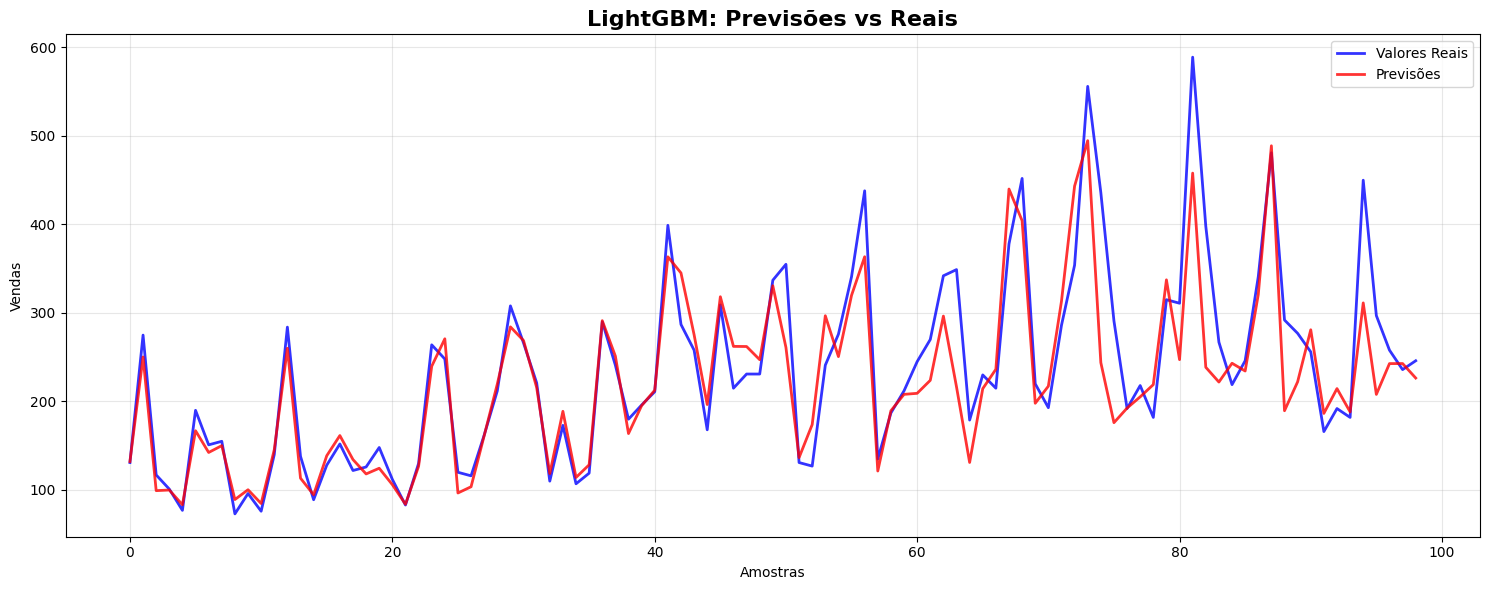

In [46]:
def plot_predictions_vs_real(y_real, y_pred, title="Previsões vs Valores Reais"):
    plt.figure(figsize=(15, 6))
    
    plt.plot(y_real.values, label='Valores Reais', linewidth=2, alpha=0.8, color='blue')
    plt.plot(y_pred, label='Previsões', linewidth=2, alpha=0.8, color='red')
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Amostras')
    plt.ylabel('Vendas')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_predictions_vs_real(y_test, lgb_preds, "LightGBM: Previsões vs Reais")

In [ ]:
def prepare_lstm_data(X, y, n_steps=14):
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
    
    X_scaled = X_scaler.fit_transform(X)
    y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))
    
    X_seq, y_seq = [], []
    for i in range(n_steps, len(X_scaled)):
        X_seq.append(X_scaled[i-n_steps:i, :])
        y_seq.append(y_scaled[i, 0])
    
    return np.array(X_seq), np.array(y_seq), X_scaler, y_scaler

def create_lstm_model(n_steps, n_features):
    """Cria arquitetura LSTM"""
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, 
             input_shape=(n_steps, n_features)),
        Dropout(0.2),
        LSTM(200, activation='relu'),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def train_lstm(X_train, y_train, X_test, y_test, n_steps=14):
    X_train_seq, y_train_seq, X_scaler, y_scaler = prepare_lstm_data(X_train, y_train, n_steps)
    X_test_seq, y_test_seq, _, _ = prepare_lstm_data(X_test, y_test, n_steps)
    
    print(f"📊 Shape LSTM:")
    print(f"X_train_seq: {X_train_seq.shape}, y_train_seq: {y_train_seq.shape}")
    print(f"X_test_seq: {X_test_seq.shape}, y_test_seq: {y_test_seq.shape}")
    
    model = create_lstm_model(n_steps, X_train_seq.shape[2])
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=10)
    ]
    
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=200,
        batch_size=32,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=callbacks,
        verbose=1
    )
    
    # Prever
    y_pred_scaled = model.predict(X_test_seq)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    
    # Métricas
    mae = mean_absolute_error(y_test[n_steps:], y_pred)
    mape = mean_absolute_percentage_error(y_test[n_steps:], y_pred)
    
    print(f"✅ LSTM Performance:")
    print(f"   MAE: {mae:.2f}")
    print(f"   MAPE: {mape:.2%}")
    
    return model, history, y_pred

X_train, X_test, y_train, y_test, feature_names = prepare_data_for_models(df)
lstm_model, lstm_history, lstm_preds = train_lstm(X_train, y_train, X_test, y_test)

📊 Shape LSTM:
X_train_seq: (378, 14, 18), y_train_seq: (378,)
X_test_seq: (85, 14, 18), y_test_seq: (85,)
Epoch 1/200
12/12 [==============================] - 2s 37ms/step - loss: 0.8970 - mae: 0.7021 - val_loss: 0.7929 - val_mae: 0.6905 - lr: 0.0010
Epoch 2/200
12/12 [==============================] - 0s 17ms/step - loss: 0.8135 - mae: 0.6411 - val_loss: 0.7464 - val_mae: 0.6881 - lr: 0.0010
Epoch 3/200
12/12 [==============================] - 0s 14ms/step - loss: 0.7935 - mae: 0.6635 - val_loss: 0.8495 - val_mae: 0.6692 - lr: 0.0010
Epoch 4/200
12/12 [==============================] - 0s 16ms/step - loss: 0.7889 - mae: 0.6380 - val_loss: 0.7478 - val_mae: 0.6885 - lr: 0.0010
Epoch 5/200
12/12 [==============================] - 0s 14ms/step - loss: 0.7530 - mae: 0.6365 - val_loss: 0.7446 - val_mae: 0.6572 - lr: 0.0010
Epoch 6/200
12/12 [==============================] - 0s 14ms/step - loss: 0.7589 - mae: 0.6482 - val_loss: 0.7448 - val_mae: 0.6659 - lr: 0.0010
Epoch 7/200
12/12 [=====

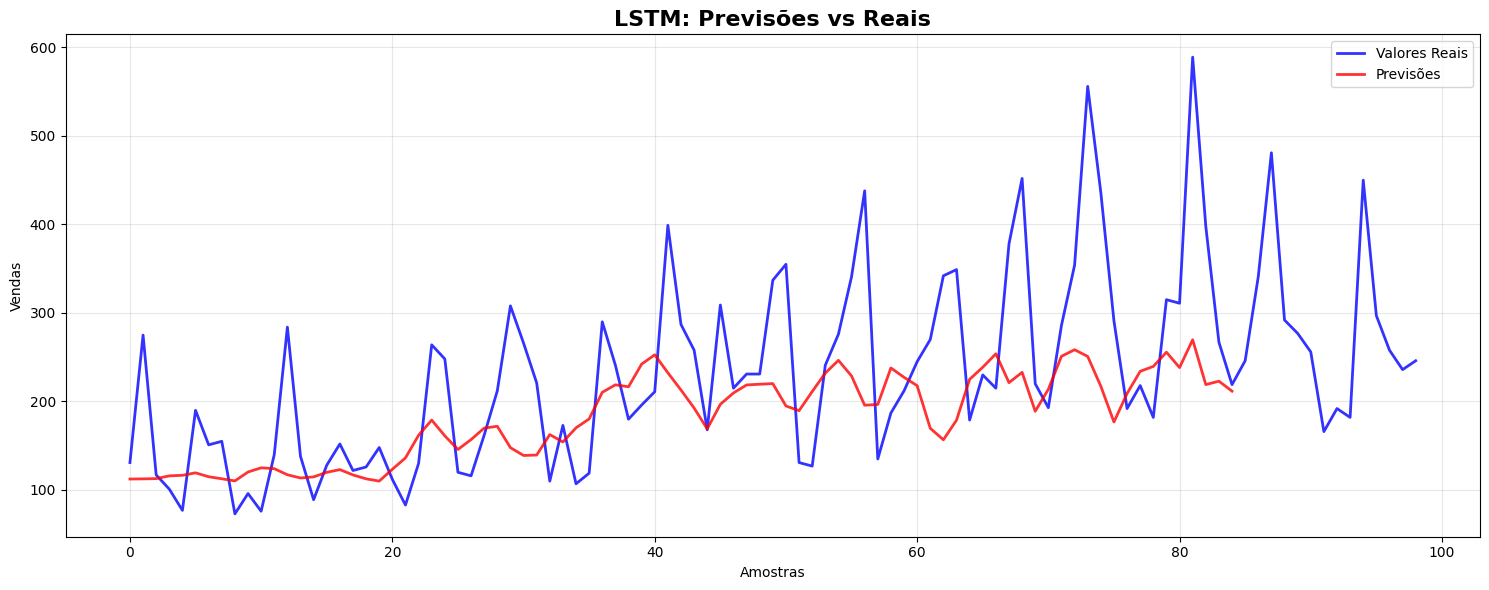

In [48]:
plot_predictions_vs_real(y_test, lstm_preds, "LSTM: Previsões vs Reais")

In [49]:
def prepare_sarimax_data(df, target_col='vendas'):
   
    df = df.sort_values('data').reset_index(drop=True)
    y = df[target_col]
    exog_vars = ['em_promocao', 'feriado_nacional', ]
    available_exog = [var for var in exog_vars if var in df.columns]
    print(f"Variáveis exógenas disponíveis: {available_exog}")
    
    if available_exog:
        X = df[available_exog]
    else:
        X = None
    
    return y, X, df['data']

y, X, dates = prepare_sarimax_data(dfr)
print(f"Série temporal: {len(y)} observações")
if X is not None:
    print(f"Variáveis exógenas: {X.shape}")

Variáveis exógenas disponíveis: ['em_promocao', 'feriado_nacional']
Série temporal: 491 observações
Variáveis exógenas: (491, 2)


In [50]:
def sarimax_temporal_split(y, X=None, test_size=0.2):
    """
    Split temporal mantendo a estrutura de séries temporais
    """
    n_test = int(len(y) * test_size)
    
    # Split da série target
    y_train, y_test = y.iloc[:-n_test], y.iloc[-n_test:]
    
    # Split das variáveis exógenas (se existirem)
    if X is not None:
        X_train, X_test = X.iloc[:-n_test], X.iloc[-n_test:]
    else:
        X_train, X_test = None, None
    
    print(f"📊 Split SARIMAX:")
    print(f"   Train: {len(y_train)} observações")
    print(f"   Test:  {len(y_test)} observações")
    
    return y_train, y_test, X_train, X_test

# Fazer split
y_train, y_test, X_train, X_test = sarimax_temporal_split(y, X, test_size=0.2)

📊 Split SARIMAX:
   Train: 393 observações
   Test:  98 observações


In [51]:
def train_sarimax(y_train, X_train=None, order=(1,1,1), seasonal_order=(1,1,1,7)):
    """
    Treina modelo SARIMAX com os parâmetros especificados
    """
    print(f"🔧 Treinando SARIMAX{order}{seasonal_order}...")
    
    try:
        if X_train is not None:
            model = SARIMAX(
                endog=y_train,
                exog=X_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
        else:
            model = SARIMAX(
                endog=y_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
        
        # Ajustar modelo
        results = model.fit(disp=False, maxiter=200)
        
        print("✅ Modelo treinado com sucesso!")
        print(results.summary())
        
        return results
        
    except Exception as e:
        print(f"❌ Erro no treinamento: {e}")
        return None

# Treinar modelo básico
sarimax_results = train_sarimax(
    y_train, 
    X_train,
    order=(1, 1, 1), 
    seasonal_order=(1, 1, 1, 7)  # Sazonalidade semanal
)

🔧 Treinando SARIMAX(1, 1, 1)(1, 1, 1, 7)...
✅ Modelo treinado com sucesso!
                                     SARIMAX Results                                     
Dep. Variable:                            vendas   No. Observations:                  393
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -2039.086
Date:                           Sun, 14 Sep 2025   AIC                           4092.172
Time:                                   17:18:30   BIC                           4119.680
Sample:                                        0   HQIC                          4103.092
                                           - 393                                         
Covariance Type:                             opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
em_promocao         88.3350      5.

In [52]:
def sarimax_predict_and_evaluate(results, y_test, X_test=None, steps_ahead=1):
    """
    Faz previsões e avalia o modelo
    """
    if results is None:
        return None, None, None
    
    try:
        # Fazer previsões
        if X_test is not None:
            forecast = results.get_forecast(steps=len(y_test), exog=X_test)
        else:
            forecast = results.get_forecast(steps=len(y_test))
        
        # Obter previsões e intervalos de confiança
        y_pred = forecast.predicted_mean
        conf_int = forecast.conf_int()
        
        # Métricas
        mae = mean_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        
        print(f"🎯 Performance SARIMAX:")
        print(f"   MAE:  {mae:.2f}")
        print(f"   MAPE: {mape:.2%}")
        
        return y_pred, conf_int, mae
        
    except Exception as e:
        print(f"❌ Erro nas previsões: {e}")
        return None, None, None

# Fazer previsões
y_pred_sarimax, conf_int, mae_sarimax = sarimax_predict_and_evaluate(
    sarimax_results, y_test, X_test
)

🎯 Performance SARIMAX:
   MAE:  116.52
   MAPE: 43.15%


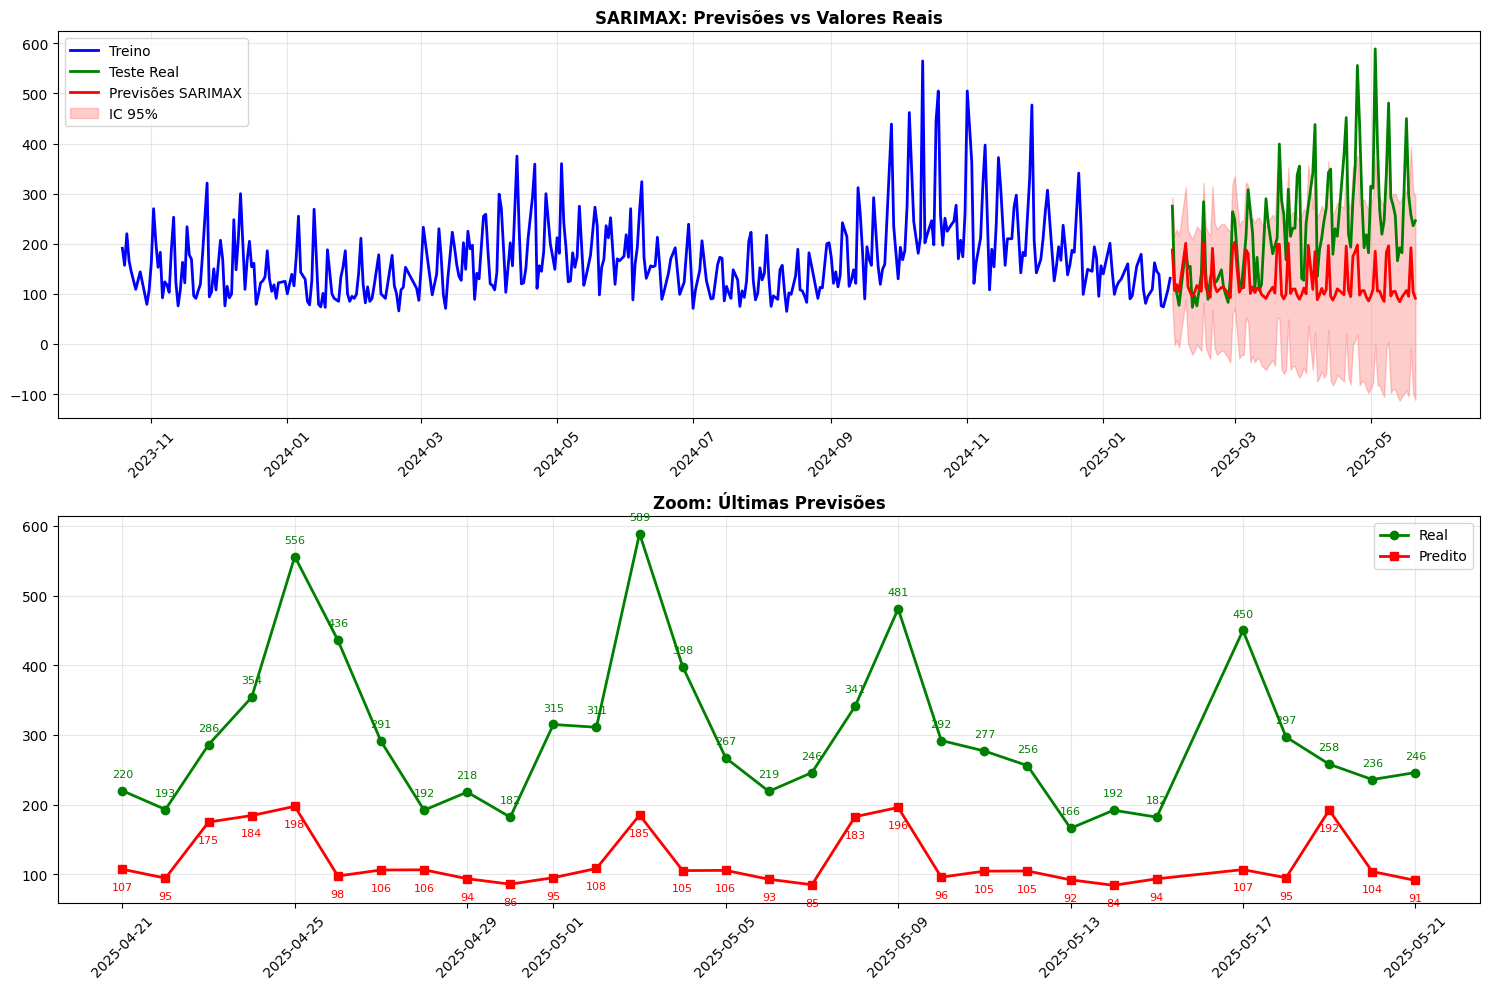

In [53]:
def plot_sarimax_results(y_train, y_test, y_pred, conf_int, dates):
    """
    Plota resultados do SARIMAX
    """
    if y_pred is None:
        print("❌ Não há previsões para plotar")
        return
    
    plt.figure(figsize=(15, 10))
    
    # Gráfico 1: Série completa com previsões
    plt.subplot(2, 1, 1)
    
    # Treino
    train_dates = dates.iloc[:len(y_train)]
    plt.plot(train_dates, y_train, label='Treino', linewidth=2, color='blue')
    
    # Teste real
    test_dates = dates.iloc[len(y_train):len(y_train)+len(y_test)]
    plt.plot(test_dates, y_test, label='Teste Real', linewidth=2, color='green')
    
    # Previsões
    plt.plot(test_dates, y_pred, label='Previsões SARIMAX', linewidth=2, color='red')
    
    # Intervalo de confiança
    if conf_int is not None:
        plt.fill_between(test_dates, 
                        conf_int.iloc[:, 0], 
                        conf_int.iloc[:, 1], 
                        color='red', alpha=0.2, label='IC 95%')
    
    plt.title('SARIMAX: Previsões vs Valores Reais', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Gráfico 2: Zoom nas previsões
    plt.subplot(2, 1, 2)
    
    # Últimas 30 observações do teste
    n_zoom = min(30, len(y_test))
    zoom_dates = test_dates[-n_zoom:]
    zoom_y_test = y_test[-n_zoom:]
    zoom_y_pred = y_pred[-n_zoom:]
    
    plt.plot(zoom_dates, zoom_y_test, label='Real', linewidth=2, color='green', marker='o')
    plt.plot(zoom_dates, zoom_y_pred, label='Predito', linewidth=2, color='red', marker='s')
    
    # Adicionar valores
    for i, (date, real, pred) in enumerate(zip(zoom_dates, zoom_y_test, zoom_y_pred)):
        plt.annotate(f'{real:.0f}', (date, real), 
                    textcoords="offset points", xytext=(0,10), 
                    ha='center', fontsize=8, color='green')
        plt.annotate(f'{pred:.0f}', (date, pred), 
                    textcoords="offset points", xytext=(0,-15), 
                    ha='center', fontsize=8, color='red')
    
    plt.title('Zoom: Últimas Previsões', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Plotar resultados
if y_pred_sarimax is not None:
    plot_sarimax_results(y_train, y_test, y_pred_sarimax, conf_int, dates)

In [54]:

def prophet_temporal_split(prophet_df, test_size=0.2):
    """
    Split temporal para Prophet
    """
    # Ordenar por data
    prophet_df = prophet_df.sort_values('data').reset_index(drop=True)
    
    # Split baseado em data de corte
    cutoff_date = prophet_df['data'].iloc[int(len(prophet_df) * (1 - test_size))]
    
    train_df = prophet_df[prophet_df['data'] < cutoff_date]
    test_df = prophet_df[prophet_df['data'] >= cutoff_date]

    print(f"📊 Split Prophet:")
    print(f"   Train: {len(train_df)} observações ({train_df['data'].min()} até {train_df['data'].max()})")
    print(f"   Test:  {len(test_df)} observações ({test_df['data'].min()} até {test_df['data'].max()})")

    return train_df, test_df, cutoff_date

# Fazer split
train_df, test_df, cutoff_date = prophet_temporal_split(dfr, test_size=0.2)

📊 Split Prophet:
   Train: 392 observações (2023-10-19 00:00:00 até 2025-01-30 00:00:00)
   Test:  99 observações (2025-01-31 00:00:00 até 2025-05-21 00:00:00)


In [ ]:
def train_prophet_model(train_df, growth='linear', seasonality_mode='additive'):
    """
    Treina modelo Prophet com configurações otimizadas
    """
    # Inicializar modelo
    model = Prophet(
        growth=growth,
        seasonality_mode=seasonality_mode,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10.0,
        holidays_prior_scale=10.0,
        mcmc_samples=0
    )
    
    regressor_columns = [col for col in train_df.columns if col not in ['data', 'vendas']]
    
    for regressor in regressor_columns:
        model.add_regressor(regressor)
        print(f"   ✅ Regressor adicionado: {regressor}")
    
    # Treinar modelo
    print("🔧 Treinando Prophet...")
    model.fit(train_df)
    
    print("✅ Prophet treinado com sucesso!")
    return model, regressor_columns

# Treinar modelo
prophet_model, regressor_columns = train_prophet_model(train_df)

   ✅ Regressor adicionado: em_promocao
   ✅ Regressor adicionado: feriado_nacional
   ✅ Regressor adicionado: dia_da_semana_domingo
   ✅ Regressor adicionado: dia_da_semana_quarta-feira
   ✅ Regressor adicionado: dia_da_semana_quinta-feira
   ✅ Regressor adicionado: dia_da_semana_sabado
   ✅ Regressor adicionado: dia_da_semana_segunda-feira
   ✅ Regressor adicionado: dia_da_semana_sexta-feira
   ✅ Regressor adicionado: dia_da_semana_terca-feira
   ✅ Regressor adicionado: vendas_lag_1
   ✅ Regressor adicionado: vendas_lag_7
   ✅ Regressor adicionado: vendas_lag_14
   ✅ Regressor adicionado: vendas_lag_21
   ✅ Regressor adicionado: vendas_lag_28
   ✅ Regressor adicionado: vendas_media_7d
   ✅ Regressor adicionado: vendas_media_14d
   ✅ Regressor adicionado: vendas_diff_1
   ✅ Regressor adicionado: vendas_diff_7
🔧 Treinando Prophet...


ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [ ]:
def plot_prophet_results(model, forecast, train_df, test_df):
    """
    Plota resultados do Prophet
    """
    fig = model.plot(forecast)
    plt.title('Prophet: Previsões e Componentes', fontweight='bold')
    plt.show()
    
    # Plot componentes
    fig2 = model.plot_components(forecast)
    plt.suptitle('Componentes do Modelo Prophet', fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Plot comparativo detalhado
    plt.figure(figsize=(15, 10))
    
    # Gráfico 1: Série completa
    plt.subplot(2, 1, 1)
    plt.plot(train_df['ds'], train_df['y'], label='Treino', linewidth=2, color='blue')
    plt.plot(test_df['ds'], test_df['y'], label='Teste Real', linewidth=2, color='green')
    plt.plot(forecast['ds'], forecast['yhat'], label='Previsões', linewidth=2, color='red')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                    alpha=0.2, color='red', label='IC 95%')
    plt.title('Prophet: Previsões vs Valores Reais', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Gráfico 2: Zoom no período de teste
    plt.subplot(2, 1, 2)
    n_zoom = min(30, len(test_df))
    zoom_dates = test_df['ds'].iloc[-n_zoom:]
    zoom_real = test_df['y'].iloc[-n_zoom:]
    zoom_pred = forecast['yhat'].iloc[-n_zoom:]
    
    plt.plot(zoom_dates, zoom_real, label='Real', linewidth=2, color='green', marker='o')
    plt.plot(zoom_dates, zoom_pred, label='Predito', linewidth=2, color='red', marker='s')
    
    # Adicionar valores
    for i, (date, real, pred) in enumerate(zip(zoom_dates, zoom_real, zoom_pred)):
        plt.annotate(f'{real:.0f}', (date, real), 
                    textcoords="offset points", xytext=(0,10), 
                    ha='center', fontsize=8, color='green')
        plt.annotate(f'{pred:.0f}', (date, pred), 
                    textcoords="offset points", xytext=(0,-15), 
                    ha='center', fontsize=8, color='red')
    
    plt.title('Zoom: Últimas Previsões', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Plotar resultados
plot_prophet_results(prophet_model, forecast, train_df, test_df)